Copyright 2023, [Themis AI, Inc.](https://themisai.io) All Rights Reserved.

We now have trained a Bayesian NN that "knows what it does not know"!

Let's use it to make some predictions and detect its failures on challenging datapoints and out-of-distribution (OOD) data.

In [ ]:
def predict_with_uncertainty(inputs, num_stochastic_samples=10, model=model):
  """ Stochastically samples multiple forward passes through the network and
  compute the prediction and uncertainty of the model by taking the mean and
  standard deviation (respectively) over the sampled outputs. Remember to pass
  the sampled logits through a softmax before computing the mean and std.

  Returns a tuple of the estimated prediction (mean) and uncertainty (std)
  over the predicted probabilities. """


  """ TODO: evaluate `num_stochastic_samples` forward passes through the model """
  pass
  #inputs: batch, image
  #outputs: batch, 10 output dims
  all_samples = []

  for i in range(num_stochastic_samples):
    logits = model(inputs)
    #softmax accross 10 predictions
    soft_maxed = nn.functional.softmax(logits, dim=1)
    all_samples.append(soft_maxed)


  #get the mean and stdec across all_samples
  all_samples = torch.stack(all_samples, 0)


  """ TODO: compute the final prediction """
  pass

  """ TODO: compute the final uncertainty """
  pass

  prediction = all_samples.mean(dim=0).to('cpu')
  uncertainty = all_samples.std(dim=0).to('cpu')



  #now prediction and uncertainty are batch by 10, agregate uncertaintieswith mean

  return prediction.detach().numpy(), uncertainty.detach().numpy().mean(axis=1)

In [ ]:
#NEXT SECTION IS A BAYESIAN CNN ON CIFAR MERGED IMAGES
#SEE https://docs.google.com/presentation/d/1kzDLA1UDoog5mm0pEZ0oucuKWdZWhhjUk2M8I9qS_9I/edit?usp=sharing
#@jssteele@mit.edu with questions

#CIFAR DATASET
train_set = datasets.CIFAR10(root='./data', train=True, download=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True)
#being too slow, change subset
subset = 50000 #1000
x_train, y_train = train_set.data[:subset]/255., torch.tensor(train_set.targets[:subset])
x_test, y_test = test_set.data[:subset]/255., torch.tensor(test_set.targets[:subset])



#Black and white since the numbers had only 1 channel, so keeping similar
x_train = torch.tensor(x_train.mean(axis=-1))
x_test = torch.tensor(x_test.mean(axis=-1))
new_train = x_train
new_test = x_test


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#linear model for cifar
model_cifar = create_model(LinearLayer=LinearBayesian, img_size=32, num_classes=10)
model_cifar.to(device)


model_cifar = train(model_cifar)

epoch: 0  ||  loss: 2.0185  ||  acc: 30.74%
epoch: 1  ||  loss: 1.9888  ||  acc: 33.70%
epoch: 2  ||  loss: 1.9252  ||  acc: 33.82%
epoch: 3  ||  loss: 1.8419  ||  acc: 36.74%
epoch: 4  ||  loss: 1.7883  ||  acc: 37.00%
epoch: 5  ||  loss: 1.6983  ||  acc: 37.78%
epoch: 6  ||  loss: 1.7161  ||  acc: 39.42%
epoch: 7  ||  loss: 1.6829  ||  acc: 38.80%
epoch: 8  ||  loss: 1.6224  ||  acc: 38.37%
epoch: 9  ||  loss: 1.6205  ||  acc: 39.28%


In [ ]:
y_test_pred, y_test_unc = predict_with_uncertainty(x_test.to(device), num_stochastic_samples=10, model=model_cifar)

inds_sorted_by_unc = np.argsort(y_test_unc)

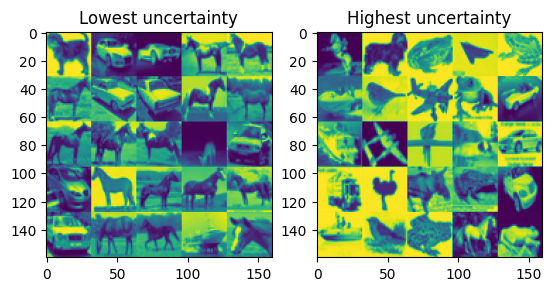

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(plot_grid(x_test[inds_sorted_by_unc[:25]])); ax[0].set_title("Lowest uncertainty");
ax[1].imshow(plot_grid(x_test[inds_sorted_by_unc[-25:]])); ax[1].set_title("Highest uncertainty");

In [ ]:

import torch.nn.functional as F
import math

class ConvBayesian(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvBayesian, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        #simplified cnn with 1 channel
        self.weight_mu = nn.Parameter(torch.Tensor(1, 1, kernel_size, kernel_size))
        self.weight_logvar = nn.Parameter(torch.Tensor(1, 1, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        #learnable parameters
        nn.init.normal_(self.weight_mu, 0, 0.1)
        nn.init.normal_(self.weight_logvar, -5, 0.1)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        x = x.float()
        if len(x.shape) == 3: #a fix
          x = x.unsqueeze(1)


        weight_std = 2.718**self.weight_logvar
        es = torch.randn((1, 1, self.kernel_size, self.kernel_size)).to('cuda')
        #w = m + e s
        weight = self.weight_mu + es * weight_std

        #run the kernel accross
        return F.conv2d(x, weight, self.bias, self.stride, self.padding)





In [ ]:
def create_cnn_model(LinearLayer, CnnLayer, img_size, num_classes):

    cmodel = nn.Sequential(
        CnnLayer(1, 1, kernel_size=3, stride=1, padding=1),  \
        nn.ReLU(),
        CnnLayer(1, 1, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        CnnLayer(1, 1, kernel_size=3, stride=1, padding=1),
       # why is adding more layers here breaking it
        nn.Flatten(),
        LinearLayer(img_size * img_size, 128),
        nn.ReLU(),
        LinearLayer(128, num_classes),
    )
    return cmodel


In [ ]:
def cnn_train(model, epochs=10, batch_size=32, lr=0.001):
  num_iters = x_train.shape[0] // batch_size
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    model.train()
    for iter in range(num_iters):
      i_start = iter * batch_size
      x_batch = x_train[i_start : i_start+batch_size].to(device)
      y_batch = y_train[i_start : i_start+batch_size].to(device)

      optimizer.zero_grad()
      y_pred = model(x_batch)
      #print("loss sizes", y_pred.shape, y_batch.shape)
      loss = loss_fn(y_pred, y_batch)
      loss.backward()
      optimizer.step()

    model.eval()
    y_pred = model(x_test.to(device))
    cls_pred = y_pred.argmax(dim=1, keepdim=True).cpu().numpy()
    accuracy = np.mean(cls_pred[:,0] == y_test.numpy())
    print(f"epoch: {epoch}  ||  loss: {loss:.4f}  ||  acc: {100*accuracy:.2f}%")

  return model

In [ ]:
cnn_model = create_cnn_model(LinearBayesian, ConvBayesian, img_size=32, num_classes=10)
cnn_model.to(device)
trained_model = cnn_train(cnn_model)

epoch: 0  ||  loss: 1.8375  ||  acc: 37.60%
epoch: 1  ||  loss: 1.7205  ||  acc: 40.71%
epoch: 2  ||  loss: 1.6199  ||  acc: 41.86%
epoch: 3  ||  loss: 1.6043  ||  acc: 42.46%
epoch: 4  ||  loss: 1.5484  ||  acc: 42.99%
epoch: 5  ||  loss: 1.4632  ||  acc: 43.73%
epoch: 6  ||  loss: 1.3619  ||  acc: 43.52%
epoch: 7  ||  loss: 1.3116  ||  acc: 43.68%
epoch: 8  ||  loss: 1.3338  ||  acc: 43.22%
epoch: 9  ||  loss: 1.2437  ||  acc: 43.22%


In [ ]:
def fade_plot(model):

  #demo of certainty across merged images of a car and horse
  #car and horse
  desired_label_1 = 1
  desired_label_2 = 7
  num_images = 1
  steps = 6  # number of fading steps

  steps_plot = np.linspace(0, 1, steps)

  images_of_ones = find_images_with_label(new_test, y_test, desired_label_1)
  images_of_twos = find_images_with_label(new_test, y_test, desired_label_2)
  images_of_ones = images_of_ones[:num_images]
  images_of_twos = images_of_twos[:num_images]



  #fading from one to the other
  def fade_images(image_pair, steps):
      img1, img2 = image_pair
      alpha_values = torch.linspace(0, 1, steps)
      for alpha in alpha_values:
          yield (1 - alpha) * img1 + alpha * img2



  num_images = images_of_ones.size(0)


  #overkill since just ended up doing one image each
  faded_lists = [fade_images((images_of_ones[i, :, :], images_of_twos[i, :, :]), steps) for i in range(num_images)]

  fades = np.array([np.stack(fade_list) for fade_list in faded_lists])
  print(fades.shape)

  grid = np.mean(fades, axis=0)

  print(grid.shape)

  print("Visualizing the network predictions and uncertainties")
  ## 1. Visualize the inference data
  fig = plt.figure(figsize=(16, 10))
  for i in range(grid.shape[0]):
      ax = fig.add_subplot(1, grid.shape[0], i+1)
      plt.imshow(grid[i])
      ax.set_axis_off()
  plt.savefig('/content/inference_data.png', bbox_inches='tight')
  plt.close()

  ## 2. Compute the model predictions

  num_imgs, fade_steps, height, width = fades.shape
  inputs = torch.from_numpy(fades.reshape(-1, height, width)).to(device)
  pred, unc = predict_with_uncertainty(inputs, model=model)
  pred, unc = [arr.reshape(num_imgs, fade_steps, -1).mean(0) for arr in (pred, unc)]

  ## 3. Visualize the model predictions
  fig, ax = plt.subplots()
  cls, counts = np.unique(pred.argmax(1), return_counts=True)
  top_2_classes = cls[np.argsort(counts)[-2:]][::-1]

  plt.plot(steps_plot, pred[:, desired_label_2], label=f"P(HORSE)")
  plt.plot(steps_plot, pred[:, desired_label_1], label=f"P(CAR)")

  plt.plot(steps_plot, normalize(unc), '-k', label="uncertainty")
  plt.legend(loc="upper right")

  im = mpimg.imread('/content/inference_data.png')
  newax = fig.add_axes([0.13, -0.01, 0.75, 6], anchor='S', zorder=1)
  newax.imshow(im)
  newax.axis('off');

<ipython-input-23-ac6efdc31fe8>:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fade_plot(model_cifar)


(1, 6, 32, 32)
(6, 32, 32)
Visualizing the network predictions and uncertainties


<ipython-input-23-ac6efdc31fe8>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  fade_plot(cnn_model)


(1, 6, 32, 32)
(6, 32, 32)
Visualizing the network predictions and uncertainties


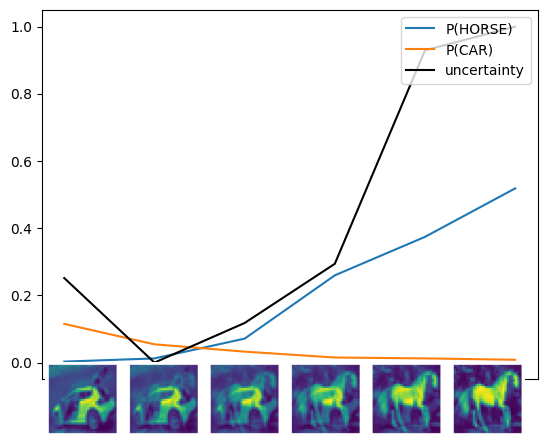

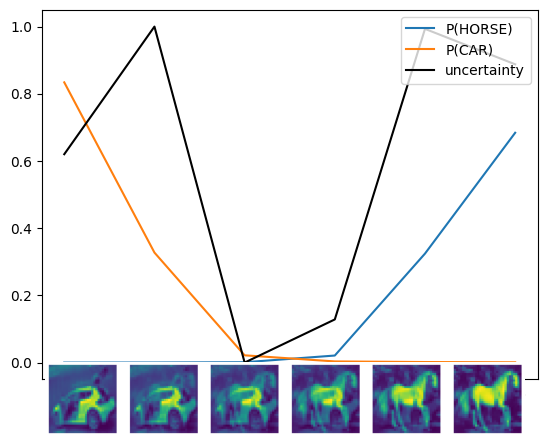

In [ ]:
fade_plot(model_cifar)
fade_plot(cnn_model)